In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA

from library.dataset import MriDataset
from library.db_module import Db
from library.queries import get_patients_with_head_mri_images
from scripts.main import get_image_ids
from matplotlib import pyplot as plt
import torchio as tio

LABEL_DICT = {0: 'No Stroke', 1: 'Stroke'}
def create_pca(db_fpath: str, dicom_dir: str, json_dir: str) -> None:
    with Db(db_fpath) as db:
        query_results = db.query(get_patients_with_head_mri_images())

    final_results = get_image_ids(json_dir, query_results)

    transforms = tio.Compose([
    tio.Resample((1, 1, 1)),  # Resample to isotropic voxel size of 1mm
    tio.ZNormalization(),     # Normalize intensities (mean 0, std 1)
])

    dataset = MriDataset(final_results, dicom_dir, transforms).to_subject_dataset()

    flat_data = [sub['mri'].data.flatten().numpy() for sub in dataset]
    labels = [sub['stroke_flag'] for sub in dataset]
    preprocessed_array = np.stack(flat_data)

    print("Running Normalizaton")

    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(preprocessed_array)

    print("Running PCA")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(normalized_data)

    print("Plotting")

    # Visualize the clusters with labels
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(
            pca_result[idx, 0],
            pca_result[idx, 1],
            label=LABEL_DICT[label]
        )

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization of MRI Data with Labels')
    plt.legend()
    plt.show()

Patient Chang901 Bayer639 does not have FHIR data
Patient Suzette512 Murazik203 does not have MRI images at /Users/arodriguez/Downloads/coherent-11-07-2022/dicom/Suzette512_Murazik203_0f5ba449-9506-e344-e68b-9cab5592ce4b1.2.840.99999999.92623995.1524899262212.dcm
Patient Ben667 Schmitt836 does not have MRI images at /Users/arodriguez/Downloads/coherent-11-07-2022/dicom/Ben667_Schmitt836_380c9cb5-583f-1bde-eb92-ee44cb55eeb61.2.840.99999999.37232251.1573334171518.dcm
Patient Felicitas300 Berge125 does not have MRI images at /Users/arodriguez/Downloads/coherent-11-07-2022/dicom/Felicitas300_Berge125_7a4dad5f-3b06-3104-8540-f20982d2c4c51.2.840.99999999.12025302.1504758963132.dcm
Patient Freddie621 Upton904 does not have MRI images at /Users/arodriguez/Downloads/coherent-11-07-2022/dicom/Freddie621_Upton904_7d707690-2d71-66ed-a24a-8063f7e681651.2.840.99999999.12226437.1445703879730.dcm
Patient Louie190 Weber641 does not have MRI images at /Users/arodriguez/Downloads/coherent-11-07-2022/dico

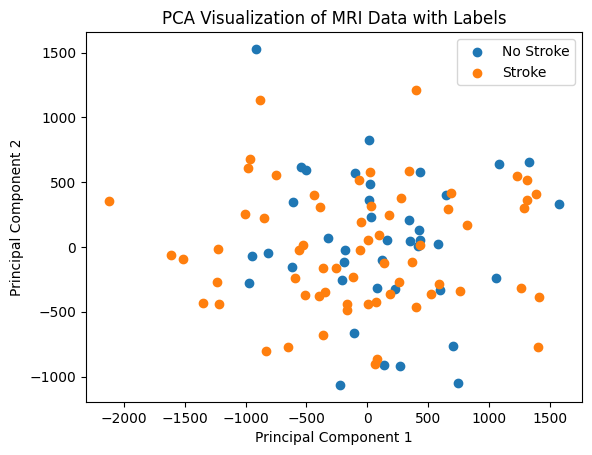

In [10]:
sqlite_fpath = "/Users/arodriguez/Desktop/FA24-high-risk-project-ai-healthcare/db_dir/coherent_data.db"
mri_dir = "/Users/arodriguez/Downloads/coherent-11-07-2022/dicom"
fhir_dir = "/Users/arodriguez/Downloads/coherent-11-07-2022/fhir"
create_pca(sqlite_fpath, mri_dir, fhir_dir)